Original Soil Moisture Series:
Soil Moisture (mm) - ADF Statistic: -5.114
Soil Moisture (mm) - p-value: 0.000
Soil Moisture (mm) is stationary (p < 0.05).


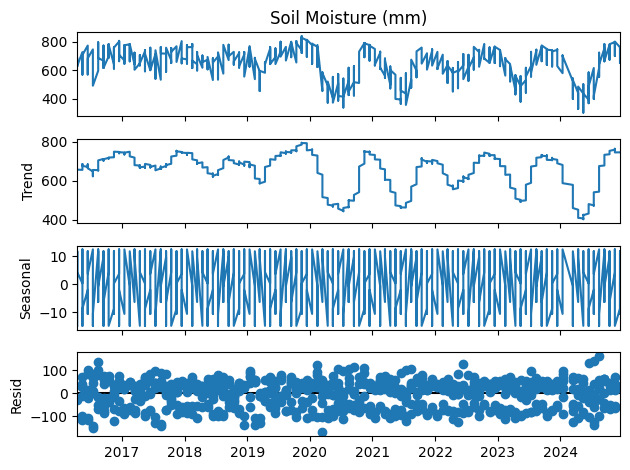

Seasonal component relative strength: 0.078


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from math import log, sqrt
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('Apayao.csv')

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y')

# Sort by time
df = df.sort_values('Time')

# Create lag features (t-1, t-2, t-3) for soil moisture
df['Soil_Moisture_Lag1'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(1)
df['Soil_Moisture_Lag2'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(2)
df['Soil_Moisture_Lag3'] = df.groupby('Municipal')['Soil Moisture (mm)'].shift(3)

# Drop rows with NaN values (first 3 rows for each municipality)
df = df.dropna()

# Define features and target
# We'll use soil moisture as a feature
X = df[['Soil_Moisture_Lag1', 'Soil_Moisture_Lag2', 'Soil_Moisture_Lag3']]
y = df['Soil Moisture (mm)']

from statsmodels.tsa.stattools import adfuller


def check_stationarity(series, signif=0.05, series_name="Series"):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"{series_name} - ADF Statistic: {result[0]:.3f}")
    print(f"{series_name} - p-value: {p_value:.3f}")
    if p_value < signif:
        print(f"{series_name} is stationary (p < {signif}).")
        return True
    else:
        print(f"{series_name} is not stationary (p >= {signif}).")
        return False


# Check stationarity for the original soil moisture data
soil_moisture_series = df['Soil Moisture (mm)']
print("Original Soil Moisture Series:")
is_stationary = check_stationarity(soil_moisture_series, series_name="Soil Moisture (mm)")

# Check for seasonality for the original soil moisture data
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index('Time')

# Extract the soil moisture series
soil_moisture_series = df['Soil Moisture (mm)']

# Decompose the series using an assumed seasonal period (e.g., 12 for monthly seasonality)
decomposition = seasonal_decompose(soil_moisture_series, model='additive', period=12)

# Plot the decomposition components
decomposition.plot()
plt.tight_layout()
plt.show()

# Estimate seasonal strength (relative standard deviation of the seasonal component)
seasonal_strength = decomposition.seasonal.std() / soil_moisture_series.std()
print(f"Seasonal component relative strength: {seasonal_strength:.3f}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test RMSE: 41.960
Test MAE: 33.179
AIC: 987.019
BIC: 998.519

Unseen RMSE: 65.771
Unseen MAE: 52.271
Unseen AIC: 619.182
Unseen BIC: 628.344


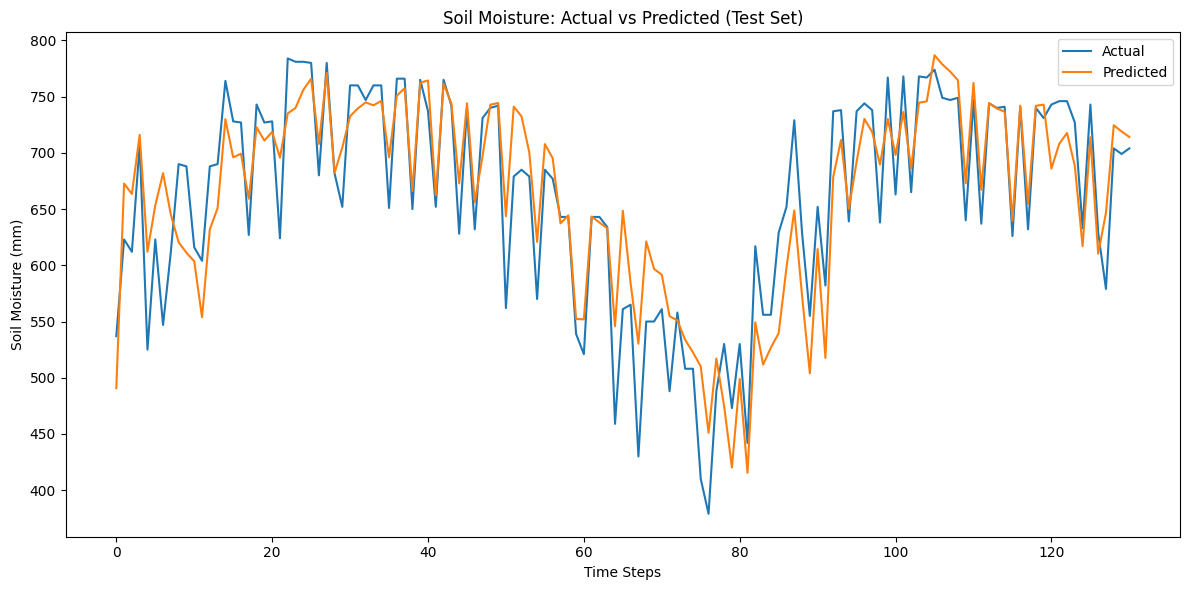

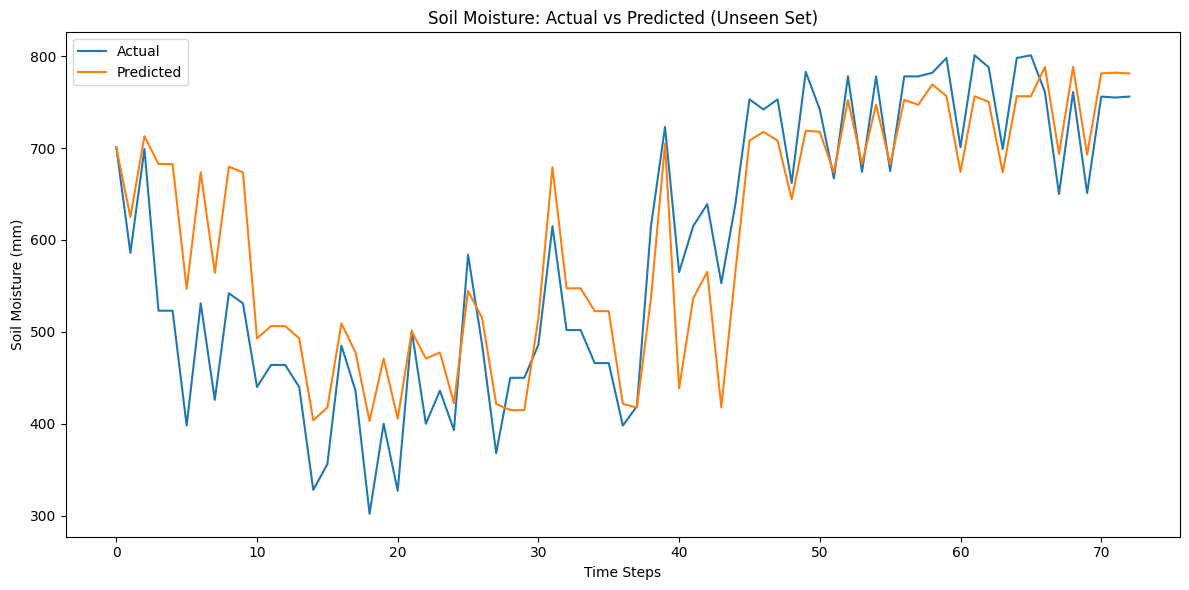

In [2]:
# Split into seen (90%) and unseen (10%) sets
seen_size = int(len(df) * 0.9)
X_seen = X[:seen_size]
y_seen = y[:seen_size]
X_unseen = X[seen_size:]
y_unseen = y[seen_size:]

# Split seen data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seen, y_seen, test_size=0.2, random_state=42, shuffle=False
)

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,  # 10-fold cross-validation
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Initialize model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)

# Implement Rolling Forecast Origin Method
# Use the training data and incrementally add test data points
train_size = len(X_train)
test_size = len(X_test)
predictions = []
actuals = []

for i in range(test_size):
    # Train on all available training data
    X_train_rolling = X_seen[:train_size + i]
    y_train_rolling = y_seen[:train_size + i]

    # Fit the model
    best_rf.fit(X_train_rolling, y_train_rolling)

    # Predict the next point
    next_pred = best_rf.predict([X_seen.iloc[train_size + i]])
    predictions.append(next_pred[0])
    actuals.append(y_seen.iloc[train_size + i])

# Calculate metrics for the test set
rmse_test = sqrt(mean_squared_error(actuals, predictions))
mae_test = mean_absolute_error(actuals, predictions)

# Calculate AIC and BIC
n = len(actuals)
k = X.shape[1] + 1  # number of parameters (+1 for intercept)
rss = sum((np.array(actuals) - np.array(predictions))**2)
mse = rss / n
aic = n * log(mse) + 2 * k
bic = n * log(mse) + k * log(n)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"AIC: {aic:.3f}")
print(f"BIC: {bic:.3f}")

# Predict on the unseen set
best_rf.fit(X_seen, y_seen)  # Train on all seen data
unseen_predictions = best_rf.predict(X_unseen)

# Calculate metrics for the unseen set
rmse_unseen = sqrt(mean_squared_error(y_unseen, unseen_predictions))
mae_unseen = mean_absolute_error(y_unseen, unseen_predictions)

# Calculate AIC and BIC for unseen data
n_unseen = len(y_unseen)
rss_unseen = sum((np.array(y_unseen) - np.array(unseen_predictions))**2)
mse_unseen = rss_unseen / n_unseen
aic_unseen = n_unseen * log(mse_unseen) + 2 * k
bic_unseen = n_unseen * log(mse_unseen) + k * log(n_unseen)

print(f"\nUnseen RMSE: {rmse_unseen:.3f}")
print(f"Unseen MAE: {mae_unseen:.3f}")
print(f"Unseen AIC: {aic_unseen:.3f}")
print(f"Unseen BIC: {bic_unseen:.3f}")

# Plot actual vs predicted for test set
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Soil Moisture: Actual vs Predicted (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Plot actual vs predicted for unseen set
plt.figure(figsize=(12, 6))
plt.plot(y_unseen.values, label='Actual')
plt.plot(unseen_predictions, label='Predicted')
plt.title('Soil Moisture: Actual vs Predicted (Unseen Set)')
plt.xlabel('Time Steps')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.tight_layout()
plt.show()


=== Time Series Analysis ===
Original Soil Moisture Series:

=== Stationarity Check for Original Soil Moisture (mm) ===
ADF Statistic: -5.1055
p-value: 0.0000
The series IS stationary (reject H0)


<Figure size 1200x800 with 0 Axes>

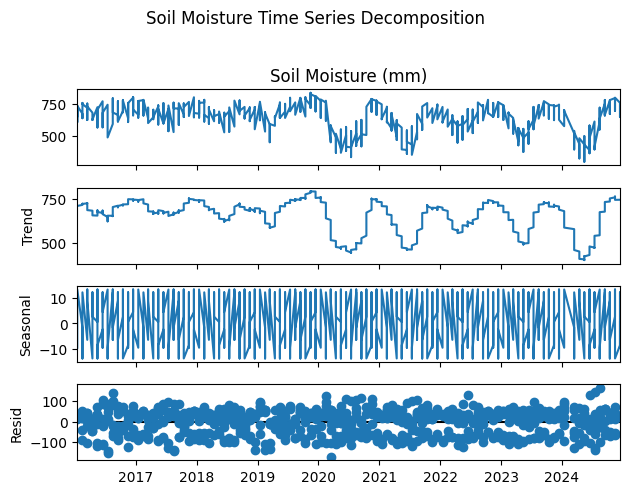


Seasonal component relative strength: 0.077
Weak or no seasonal pattern detected

=== Data Splits ===
Train dates: 2016-02-15 to 2023-02-15 (n=590)
Test dates: 2023-03-15 to 2024-01-15 (n=77)
Unseen dates: 2024-03-15 to 2024-12-15 (n=70)

Error during GridSearch: 'super' object has no attribute '__sklearn_tags__'

Falling back to default parameters...

=== Evaluation Results ===

Standard prediction on test set:
RMSE: 66.089 | MAE: 55.645 | AIC: 397191.415 | BIC: 861904.748

Standard prediction on unseen set:
RMSE: 82.432 | MAE: 67.090 | AIC: 397163.676 | BIC: 842979.573

Rolling forecast on test set:
RMSE: 68.800 | MAE: 57.099 | AIC: 397197.605 | BIC: 861910.937

Rolling forecast on unseen set:
RMSE: 87.771 | MAE: 70.556 | AIC: 397172.463 | BIC: 842988.360


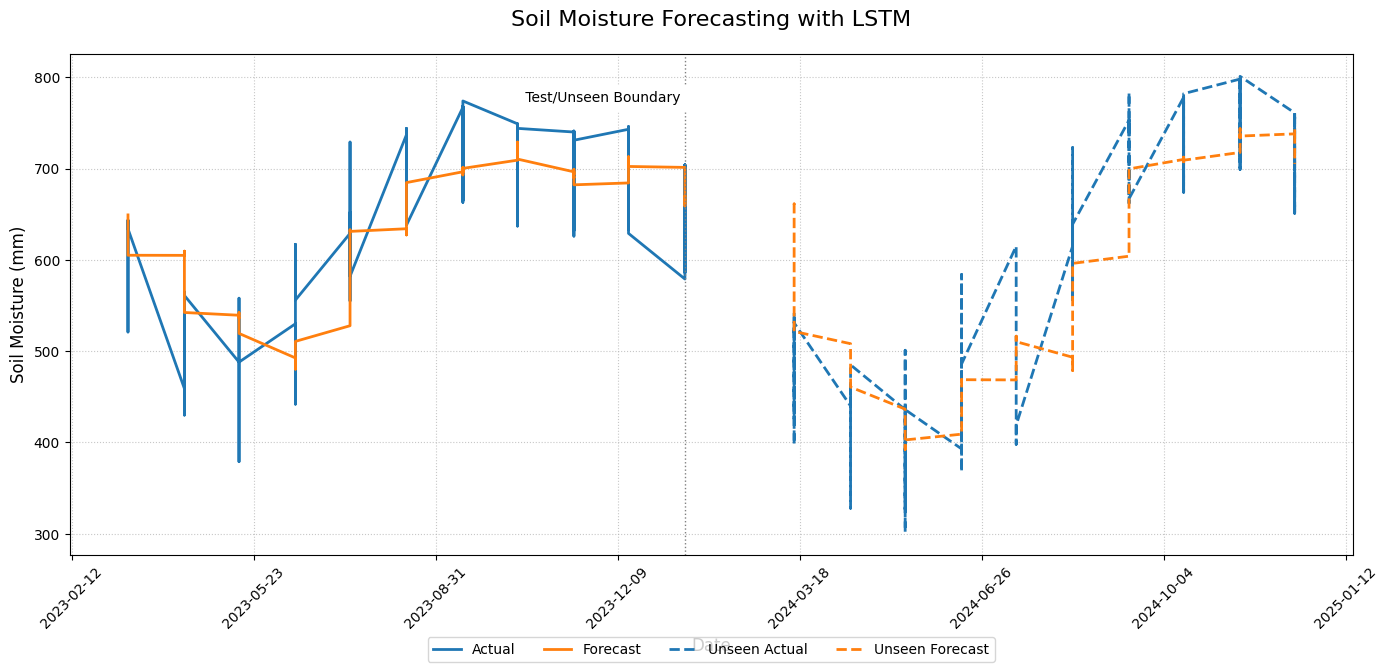

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from math import log
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# Utility Functions
# ------------------------------
def check_stationarity(series, series_name=""):
    """Perform ADF test and print results"""
    result = adfuller(series.dropna())
    test_stat, p_value = result[0], result[1]

    print(f"\n=== Stationarity Check for {series_name} ===")
    print(f"ADF Statistic: {test_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The series IS stationary (reject H0)")
        return True
    else:
        print("The series is NOT stationary (fail to reject H0)")
        return False

def inverse_scale_predictions(y_pred_scaled, scaler, features):
    """Inverse transform scaled predictions"""
    return scaler.inverse_transform(
        np.hstack([np.zeros((len(y_pred_scaled), len(features))), y_pred_scaled.reshape(-1,1)])
    )[:, -1]

def rolling_forecast(model, initial_data, X_to_predict, window_size, features):
    """Make rolling window forecasts"""
    predictions = []
    history = list(initial_data)

    for i in range(len(X_to_predict)):
        input_seq = np.array(history[-1]).reshape((1, window_size, len(features)))
        pred_scaled = model.predict_on_batch(input_seq)[0][0]
        predictions.append(pred_scaled)
        new_observation = X_to_predict[i][-1].reshape(1, -1)
        next_input = np.vstack([history[-1][1:], new_observation])
        history.append(next_input)

    return inverse_scale_predictions(np.array(predictions), scaler, features)

def compute_metrics(y_true, y_pred, k):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rss = np.sum((y_true - y_pred)**2)
    mse = rss / len(y_true)
    aic = len(y_true) * log(mse) + 2 * k
    bic = len(y_true) * log(mse) + k * log(len(y_true))
    return rmse, mae, aic, bic

# ------------------------------
# 1. Load and Preprocess Data
# ------------------------------
data = pd.read_csv('Apayao.csv')

# Convert and filter dates
data['Date'] = pd.to_datetime(data['Time'], format='%m/%d/%Y')
data = data[data['Date'].dt.year >= 2016]
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# ------------------------------
# 2. Time Series Analysis
# ------------------------------
print("\n=== Time Series Analysis ===")
soil_moisture_series = data['Soil Moisture (mm)']
print("Original Soil Moisture Series:")
is_stationary = check_stationarity(soil_moisture_series, "Original Soil Moisture (mm)")

# Seasonality Analysis
try:
    decomposition = seasonal_decompose(soil_moisture_series.dropna(),
                                    model='additive',
                                    period=12)

    plt.figure(figsize=(12,8))
    decomposition.plot()
    plt.suptitle('Soil Moisture Time Series Decomposition', y=1.02)
    plt.tight_layout()
    plt.show()

    seasonal_strength = decomposition.seasonal.std() / soil_moisture_series.std()
    print(f"\nSeasonal component relative strength: {seasonal_strength:.3f}")

    if seasonal_strength > 0.4:
        print("Strong seasonal pattern detected")
    elif seasonal_strength > 0.1:
        print("Moderate seasonal pattern detected")
    else:
        print("Weak or no seasonal pattern detected")

except ValueError as e:
    print(f"Seasonal decomposition failed: {e}")

# ------------------------------
# 3. Prepare Data for Modeling
# ------------------------------
features = ['Soil Moisture (mm)']
target = 'Soil Moisture (mm)'

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features + [target]])

X_all = scaled[:, :-1]
y_all = scaled[:, -1]

# Create sequences
window_size = 12
X_seq, y_seq = [], []
target_dates = data.index[window_size:]

for i in range(window_size, len(X_all)):
    X_seq.append(X_all[i-window_size:i, :])
    y_seq.append(y_all[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Split data
total_dates = data.index[window_size:]
split_date1 = total_dates[int(len(total_dates) * 0.8)]
split_date2 = total_dates[int(len(total_dates) * 0.9)]

train_idx = total_dates <= split_date1
test_idx = (total_dates > split_date1) & (total_dates <= split_date2)
unseen_idx = total_dates > split_date2

X_train, y_train = X_seq[train_idx], y_seq[train_idx]
dates_train = total_dates[train_idx]

X_test, y_test = X_seq[test_idx], y_seq[test_idx]
dates_test = total_dates[test_idx]

X_unseen, y_unseen = X_seq[unseen_idx], y_seq[unseen_idx]
dates_unseen = total_dates[unseen_idx]

print("\n=== Data Splits ===")
print(f"Train dates: {dates_train.min().date()} to {dates_train.max().date()} (n={len(X_train)})")
print(f"Test dates: {dates_test.min().date()} to {dates_test.max().date()} (n={len(X_test)})")
print(f"Unseen dates: {dates_unseen.min().date()} to {dates_unseen.max().date()} (n={len(X_unseen)})")

# ------------------------------
# 4. Build and Train LSTM Model
# ------------------------------
def build_model(units=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Input(shape=(window_size, len(features))),
        LSTM(units=units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# Create the KerasRegressor with explicit sklearn compatibility
keras_reg = KerasRegressor(
    model=build_model,
    optimizer='adam',
    loss='mean_squared_error',
    epochs=50,
    batch_size=32,
    verbose=0,
    # Add these parameters for sklearn compatibility
    random_state=42,
    optimizer__learning_rate=0.001
)

# Update parameter grid
param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [50],
    'batch_size': [16, 32],
    'optimizer__learning_rate': [0.001, 0.01]
}

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Create GridSearchCV with error handling
try:
    grid = GridSearchCV(
        estimator=keras_reg,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=1  # Set to 1 to avoid potential multiprocessing issues
    )
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_.model_

    print(f'\nBest Params: {grid_result.best_params_}')
    k = best_model.count_params()

except Exception as e:
    print(f"\nError during GridSearch: {e}")
    print("\nFalling back to default parameters...")
    # Fallback to a default model if GridSearch fails
    best_model = build_model()
    best_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    k = best_model.count_params()

# ------------------------------
# 5. Make Predictions
# ------------------------------
# Standard predictions
y_test_pred = inverse_scale_predictions(best_model.predict(X_test, verbose=0), scaler, features)
y_test_true = inverse_scale_predictions(y_test, scaler, features)

y_unseen_pred = inverse_scale_predictions(best_model.predict(X_unseen, verbose=0), scaler, features)
y_unseen_true = inverse_scale_predictions(y_unseen, scaler, features)

# Rolling forecasts
rolling_preds_test = rolling_forecast(best_model, list(X_train), X_test, window_size, features)
rolling_preds_unseen = rolling_forecast(best_model, list(np.vstack((X_train, X_test))), X_unseen, window_size, features)

# ------------------------------
# 6. Evaluate Results
# ------------------------------
metrics_test = compute_metrics(y_test_true, y_test_pred, k)
metrics_unseen = compute_metrics(y_unseen_true, y_unseen_pred, k)
metrics_roll_test = compute_metrics(y_test_true, rolling_preds_test, k)
metrics_roll_unseen = compute_metrics(y_unseen_true, rolling_preds_unseen, k)

print("\n=== Evaluation Results ===")
print(f"\nStandard prediction on test set:")
print(f"RMSE: {metrics_test[0]:.3f} | MAE: {metrics_test[1]:.3f} | AIC: {metrics_test[2]:.3f} | BIC: {metrics_test[3]:.3f}")

print(f"\nStandard prediction on unseen set:")
print(f"RMSE: {metrics_unseen[0]:.3f} | MAE: {metrics_unseen[1]:.3f} | AIC: {metrics_unseen[2]:.3f} | BIC: {metrics_unseen[3]:.3f}")

print(f"\nRolling forecast on test set:")
print(f"RMSE: {metrics_roll_test[0]:.3f} | MAE: {metrics_roll_test[1]:.3f} | AIC: {metrics_roll_test[2]:.3f} | BIC: {metrics_roll_test[3]:.3f}")

print(f"\nRolling forecast on unseen set:")
print(f"RMSE: {metrics_roll_unseen[0]:.3f} | MAE: {metrics_roll_unseen[1]:.3f} | AIC: {metrics_roll_unseen[2]:.3f} | BIC: {metrics_roll_unseen[3]:.3f}")

# ------------------------------
# 7. Visualize Results
# ------------------------------
plt.figure(figsize=(14, 7))

# Plot test period
plt.plot(dates_test, y_test_true, color='#1f77b4', linewidth=2, label='Test Actual')
plt.plot(dates_test, rolling_preds_test, color='#ff7f0e', linestyle='-', linewidth=2, label='Test Forecast')

# Plot unseen period
plt.plot(dates_unseen, y_unseen_true, color='#1f77b4', linestyle='--', linewidth=2, label='Unseen Actual')
plt.plot(dates_unseen, rolling_preds_unseen, color='#ff7f0e', linestyle='--', linewidth=2, label='Unseen Forecast')

# Add split line
split_date = dates_test[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1)
plt.text(split_date, plt.ylim()[1]*0.95, ' Test/Unseen Boundary ',
         ha='right', va='top', backgroundcolor='white')

# Format plot
plt.title('Soil Moisture Forecasting with LSTM', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Soil Moisture (mm)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(handles=[
    plt.Line2D([0], [0], color='#1f77b4', lw=2, label='Actual'),
    plt.Line2D([0], [0], color='#ff7f0e', lw=2, label='Forecast'),
    plt.Line2D([0], [0], color='#1f77b4', lw=2, linestyle='--', label='Unseen Actual'),
    plt.Line2D([0], [0], color='#ff7f0e', lw=2, linestyle='--', label='Unseen Forecast')
], loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

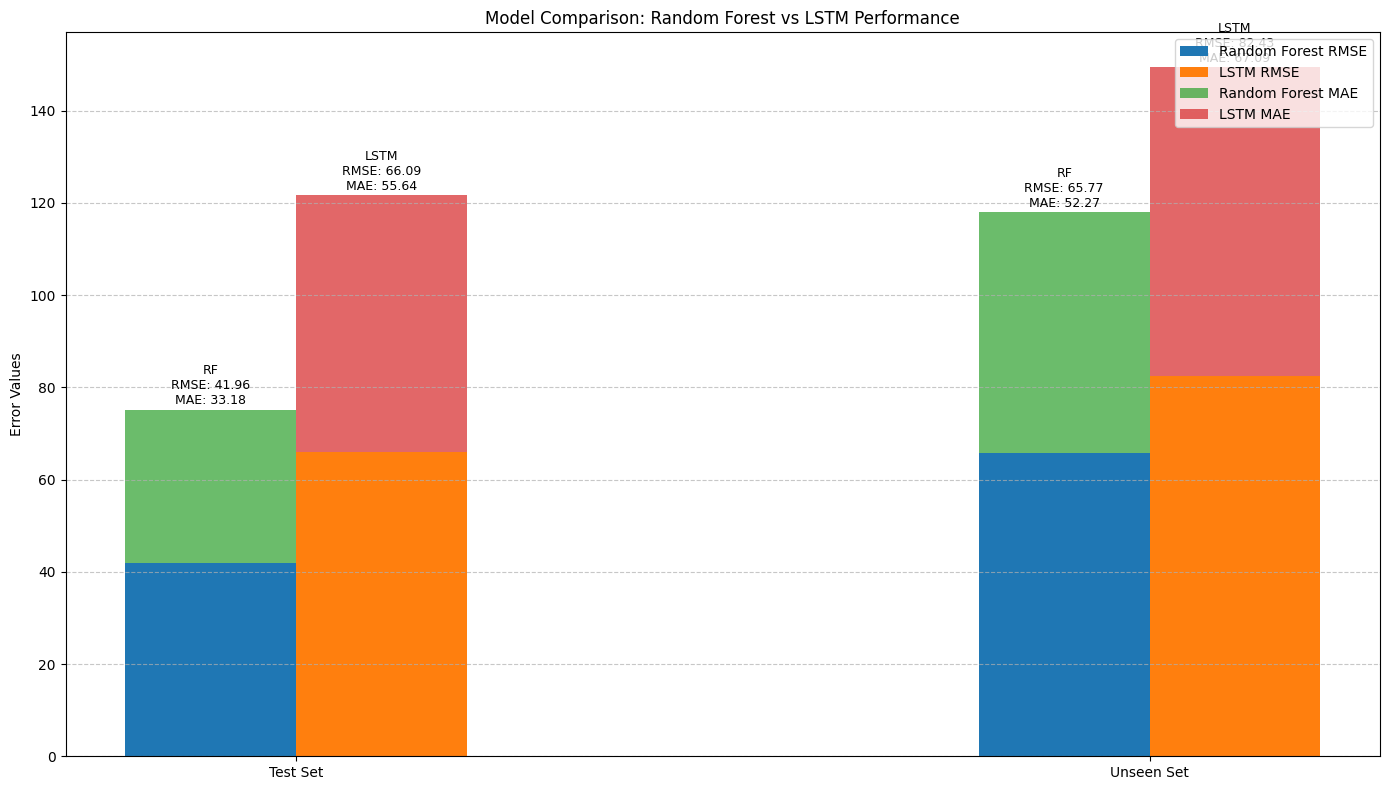

In [4]:
# After running both models, create a comparison plot
plt.figure(figsize=(14, 8))

# Create x-axis labels
x_labels = ['Test Set', 'Unseen Set']
x = np.arange(len(x_labels))
width = 0.2  # Width of the bars

# RMSE values for both models
rf_rmse = [rmse_test, rmse_unseen]
lstm_rmse = [metrics_test[0], metrics_unseen[0]]

# MAE values for both models
rf_mae = [mae_test, mae_unseen]
lstm_mae = [metrics_test[1], metrics_unseen[1]]

# Create bars
plt.bar(x - width/2, rf_rmse, width, label='Random Forest RMSE', color='#1f77b4')
plt.bar(x + width/2, lstm_rmse, width, label='LSTM RMSE', color='#ff7f0e')
plt.bar(x - width/2, rf_mae, width, label='Random Forest MAE', color='#2ca02c',
        bottom=rf_rmse, alpha=0.7)
plt.bar(x + width/2, lstm_mae, width, label='LSTM MAE', color='#d62728',
        bottom=lstm_rmse, alpha=0.7)

# Add values on top of bars
for i in range(len(x_labels)):
    plt.text(x[i] - width/2, rf_rmse[i] + rf_mae[i] + 0.5,
             f'RF\nRMSE: {rf_rmse[i]:.2f}\nMAE: {rf_mae[i]:.2f}',
             ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, lstm_rmse[i] + lstm_mae[i] + 0.5,
             f'LSTM\nRMSE: {lstm_rmse[i]:.2f}\nMAE: {lstm_mae[i]:.2f}',
             ha='center', va='bottom', fontsize=9)

# Formatting
plt.xticks(x, x_labels)
plt.ylabel('Error Values')
plt.title('Model Comparison: Random Forest vs LSTM Performance')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

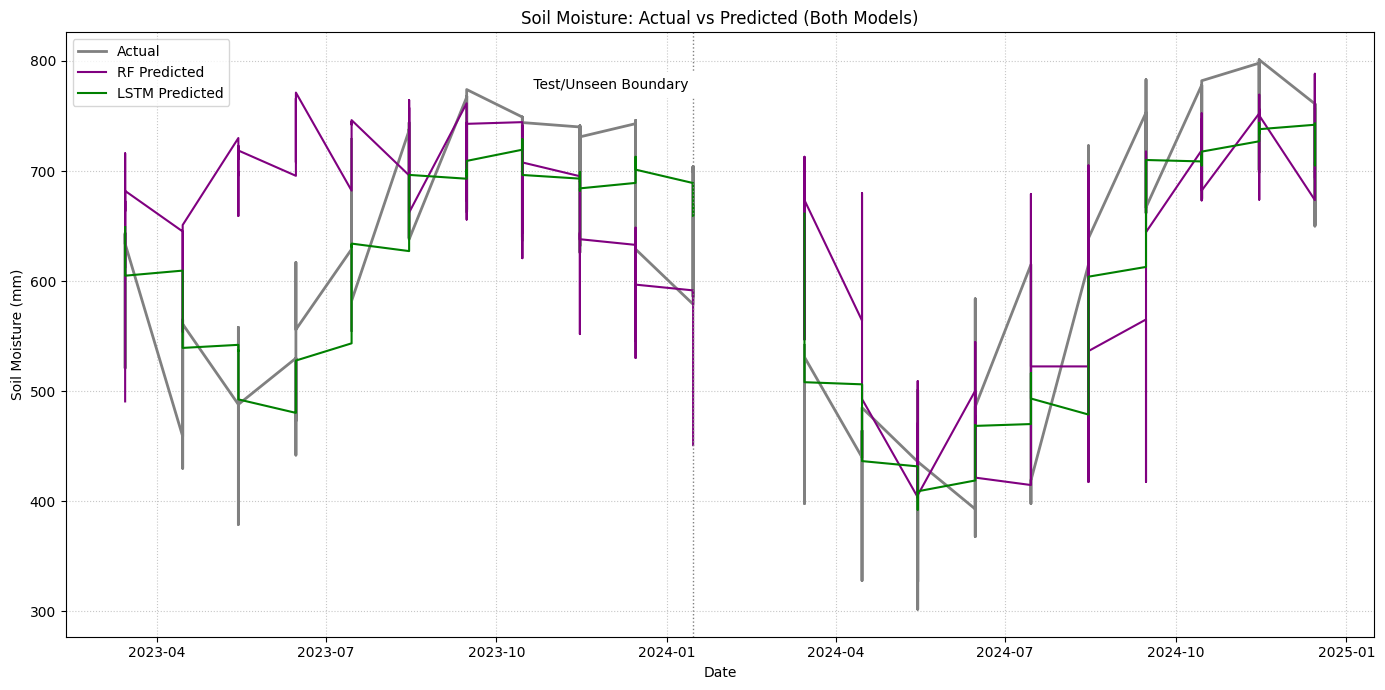

In [5]:
plt.figure(figsize=(14, 7))

rf_color = '#800080'  # Purple
lstm_color = '#008000'  # Green
actual_color = '#808080'  # Black

# Ensure all arrays have the same length
min_length = min(len(dates_test), len(predictions), len(y_test_pred))

# Plot test period (truncated to common length)
plt.plot(dates_test[:min_length], y_test_true[:min_length], color=actual_color, linewidth=2, label='Actual')
plt.plot(dates_test[:min_length], predictions[:min_length], color=rf_color, linewidth=1.5, label='RF Predicted')
plt.plot(dates_test[:min_length], y_test_pred[:min_length], color=lstm_color, linewidth=1.5, label='LSTM Predicted')

# For unseen period
min_unseen_length = min(len(dates_unseen), len(unseen_predictions), len(y_unseen_pred))

plt.plot(dates_unseen[:min_unseen_length], y_unseen_true[:min_unseen_length], color=actual_color, linewidth=2)
plt.plot(dates_unseen[:min_unseen_length], unseen_predictions[:min_unseen_length], color=rf_color, linewidth=1.5)
plt.plot(dates_unseen[:min_unseen_length], y_unseen_pred[:min_unseen_length], color=lstm_color, linewidth=1.5)

# Add split line and legend
split_date = dates_test[-1] if len(dates_test) > 0 else dates_unseen[0]
plt.axvline(x=split_date, color='gray', linestyle=':', linewidth=1)
plt.text(split_date, plt.ylim()[1]*0.95, ' Test/Unseen Boundary ',
         ha='right', va='top', backgroundcolor='white')

plt.title('Soil Moisture: Actual vs Predicted (Both Models)')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

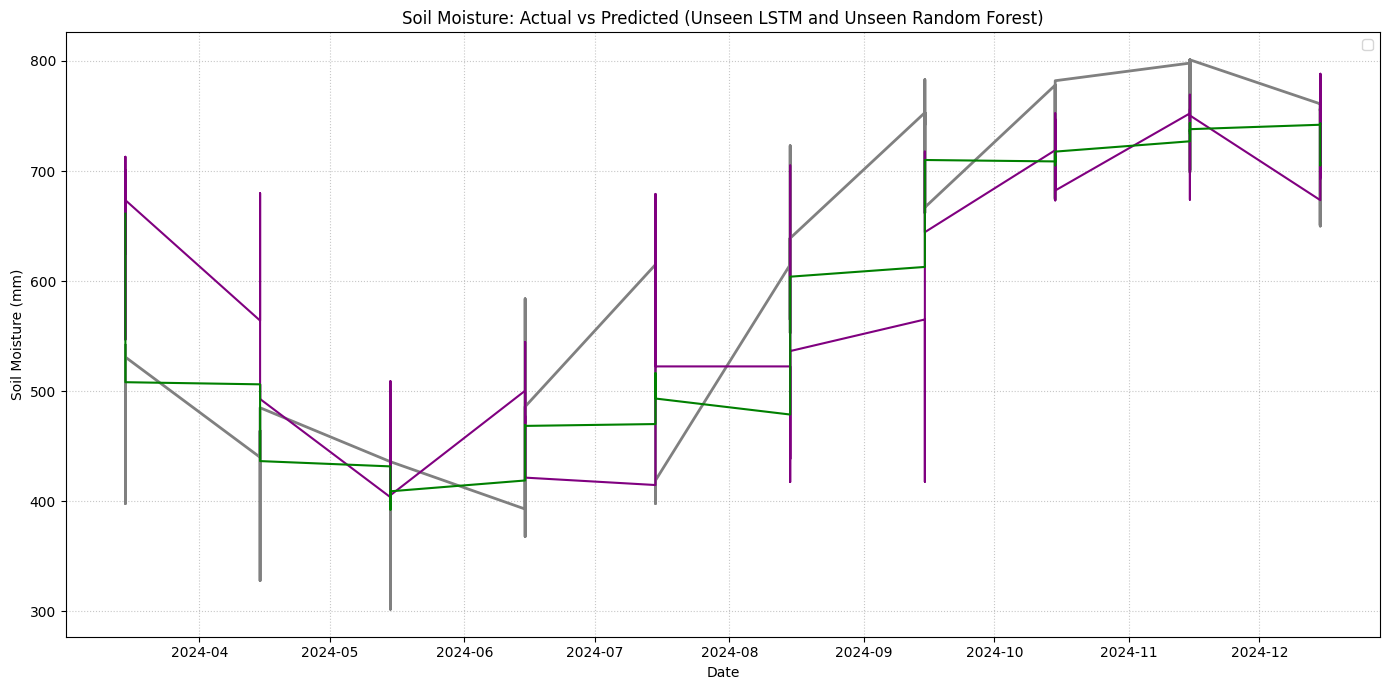

In [17]:
plt.figure(figsize=(14, 7))

rf_color = '#800080'  # Purple
lstm_color = '#008000'  # Green
actual_color = '#808080'  # Black

# Unseen period
min_unseen_length = min(len(dates_unseen), len(unseen_predictions), len(y_unseen_pred))

plt.plot(dates_unseen[:min_unseen_length], y_unseen_true[:min_unseen_length], color=actual_color, linewidth=2)
plt.plot(dates_unseen[:min_unseen_length], unseen_predictions[:min_unseen_length], color=rf_color, linewidth=1.5)
plt.plot(dates_unseen[:min_unseen_length], y_unseen_pred[:min_unseen_length], color=lstm_color, linewidth=1.5)

plt.title('Soil Moisture: Actual vs Predicted (Unseen LSTM and Unseen Random Forest)')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (mm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()